# Scikit-fingerprints intro

Scikit-fingerprints is the scikit-learn compatible library for computing molecular fingerprints and other molecular ML & chemoinformatics tasks, based on RDKit.

GitHub: https://github.com/scikit-fingerprints/scikit-fingerprints

Documentation: https://scikit-fingerprints.readthedocs.io/latest/

## Datasets

First, we will load some data - the BBBP (blood-brain barrier penetration) from [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Scikit-fingerprints has functions to download and load datasets from MoleculeNet, TDC, and others in `skfp.datasets` module ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/datasets.html)). They are hosted [on HuggingFace](https://huggingface.co/scikit-fingerprints) for high availability.

In [2]:
from skfp.datasets.moleculenet import load_bbbp


smiles_list, y = load_bbbp()

In [6]:
smiles_list[:5]

['[Cl].CC(C)NCC(O)COc1cccc2ccccc12',
 'C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl',
 'c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO3)=O',
 'C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C',
 'Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O']

In [4]:
y

array([1, 1, 1, ..., 1, 1, 1], shape=(2039,))

The task is **binary classification** - predict if a molecule can pass through the blood-brain barrier.

Let's parse SMILES as molecules. Parsing classes (input and output) are implemented as classes with `.transform()` method in scikit-fingerprints, in `skfp.preprocessing` module ([documentation](https://scikit-fingerprints.readthedocs.io/latest/modules/preprocessing.html)).

Let's compare RDKit and scikit-fingerprints. The task is to parse all SMILES as molecules.

In [11]:
from rdkit.Chem import MolFromSmiles

mols_rdkit = [MolFromSmiles(smiles) for smiles in smiles_list]
mols_rdkit[:5]

[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not removing hydrogen atom without neighbors
[17:28:44] WARNING: not r

In [12]:
from skfp.preprocessing import MolFromSmilesTransformer


mol_from_smiles = MolFromSmilesTransformer()

mols_skfp = mol_from_smiles.transform(smiles_list)
mols_skfp[:5]

[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not removing hydrogen atom without neighbors
[17:28:52] WARNING: not r

This is a list of regular RDKit `Mol` objects, we can draw them or combine with other RDKit-compatible libraries.

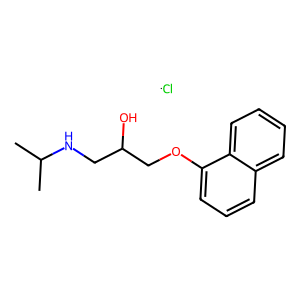

In [30]:
from rdkit.Chem import Draw

Draw.MolToImage(mols_skfp[0])

A few remarks:

1. We have inconvenient warnings. What if we want to get rid of them?
2. We may want to monitor progress.
3. What happens if we have wrong SMILES that can't be parsed?

Let's see a robust RDKit implementation that can do those things.

In [19]:
from rdkit.rdBase import DisableLog, EnableLog
from tqdm import tqdm


# we need try/finally to make sure logs are turned on after this
try:
    DisableLog("rdApp.*")

    rdkit_mols = []
    for smiles in tqdm(smiles_list):
        mol = MolFromSmiles(smiles)
        if mol is not None:
            rdkit_mols.append(mol)
finally:
    EnableLog("rdApp.*")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 15232.70it/s]


And with scikit-fingerprints:

In [20]:
mol_from_smiles = MolFromSmilesTransformer(valid_only=True, suppress_warnings=True, verbose=True)
skfp_mols = mol_from_smiles.transform(smiles_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 14836.83it/s]


One problem - if we remove some molecules, what about labels? Which ones were removed? We also need to filter them!

With RDKit, we need to iterate on both mols and labels for that.

Scikit-fingerprints has `.transform_x_y()` method for that cases, useful when you use `valid_only=True`.

In [24]:
try:
    DisableLog("rdApp.*")

    rdkit_mols = []
    rdkit_labels = []
    for smiles, label in tqdm(zip(smiles_list, y), total=len(y)):
        mol = MolFromSmiles(smiles)
        if mol is not None:
            rdkit_mols.append(mol)
            rdkit_labels.append(label)
finally:
    EnableLog("rdApp.*")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 15112.78it/s]


In [25]:
mol_from_smiles = MolFromSmilesTransformer(valid_only=True, suppress_warnings=True, verbose=True)
skfp_mols, skfp_labels = mol_from_smiles.transform_x_y(smiles_list, y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2039/2039 [00:00<00:00, 13962.64it/s]


**Exercise 1**

Load the SIDER dataset from MoleculeNet benchmark, and parse it as molecules. Keep only valid molecules and their labels, and suppress parsing warnings.

Use [scikit-fingerprints documentation](https://scikit-fingerprints.readthedocs.io/latest/api_reference.html) as necessary.

Its task is to predict adverse drug reactions (ADRs) as drug side effects to 27 system organ classes. Thus, we have 27 binary classification tasks, and a matrix of labels instead of a vector.

**Warning:** name variables so that you don't override those from BBBP, e.g. `smiles_list_sider` and `y_sider`.

In [27]:
from skfp.datasets.moleculenet import load_sider


mol_from_smiles = MolFromSmilesTransformer(valid_only=True, suppress_warnings=True)

smiles_list_sider, y_sider = load_sider()

mols_sider, y_sider = mol_from_smiles.transform_x_y(smiles_list_sider, y_sider)

## Molecular fingerprints

## Distances